In [19]:
import random
import numpy as np
import time
import pickle

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients

In [20]:
# Load both transonic and subsonic data
X_subTr = np.loadtxt('XTr.dat')
X_subV = np.loadtxt('XV.dat')
y_subCdTr = (np.loadtxt('yTr.dat')).reshape((-1,1))
y_subCdV = (np.loadtxt('yV.dat')).reshape((-1,1))
dy_subCdTr = np.loadtxt('dyTr.dat')
X_transTr = np.loadtxt('X_transTr.dat')
X_transV = np.loadtxt('X_transV.dat')
y_transCdTr = (np.loadtxt('y_transCdTr.dat')).reshape((-1,1))
y_transCdV = (np.loadtxt('y_transV.dat')).reshape((-1,1))
dy_transCdTr = np.loadtxt('dy_transCdTr.dat')

# # Read dimensions of the data
nSubTr = X_subTr.shape[0]
nSubV = X_subV.shape[0]
dimSub = X_subV.shape[1]
nTransTr = X_transTr.shape[0]
nTransV = X_transV.shape[0]
dimTrans = X_transV.shape[1]

# # Define the new design space
XTr = np.zeros((nTransTr+nSubTr,dimTrans + dimSub - 2))
XTr[:nTransTr,:dimTrans-2] = X_transTr[:,:dimTrans-2]
XTr[nTransTr:,dimTrans-2:] = X_subTr
XTr[:nTransTr,-2:] = X_transTr[:,-2:]
XV = np.zeros((nTransV+nSubV,dimTrans + dimSub - 2))
XV[:nTransV,:dimTrans-2] = X_transV[:,:dimTrans-2]
XV[nTransV:,dimTrans-2:] = X_subV
XV[:nTransV,-2:] = X_transV[:,-2:]
yTr = np.zeros((nSubTr+nTransTr,1))
yTr[:nTransTr,0] = y_transCdTr.T
yTr[nTransTr:,0] = y_subCdTr.T
yV = np.zeros((nSubV+nTransV,1))
yV[:nTransV,0] = y_transCdV.T
yV[nTransV:,0] = y_subCdV.T
dyTr = np.zeros((nTransTr+nSubTr,dimTrans + dimSub - 2))
dyTr[:nTransTr,:dimTrans-2] = dy_transCdTr[:,:dimTrans-2]
dyTr[nTransTr:,dimTrans-2:] = dy_subCdTr
dyTr[:nTransTr,-2:] = dy_transCdTr[:,-2:]
dyV = np.zeros((nTransV+nSubV,dimTrans + dimSub - 2))

In [21]:
XTr = X_subTr
XV = X_subV
yTr = y_subCdTr
yV = y_subCdV
dyTr = dy_subCdTr

In [22]:
print(X_subTr.shape)
print(X_subV.shape)
print(X_transTr.shape)
print(XTr.shape)
print(yV.shape)

(42039, 16)
(10935, 16)
(4120, 10)
(42039, 16)
(10935, 1)


# deleting data points whose cl is beyond 0.01 and 0.02
i1 = 0
tr_idx = []
va_idx = []
for t in yTr:
    if (t<0.01 or t>0.02):
        tr_idx.append(i1)
    i1 = i1+1
XTr = np.delete(XTr,tr_idx,axis=0)
yTr = np.delete(yTr,tr_idx,axis=0)
dyTr = np.delete(dyTr,tr_idx,axis=0)
i2 = 0
for t in yV:
    if t<0.01 or t>0.02:
        va_idx.append(i2)
    i2 = i2+1
#print(len(va_idx))
XV = np.delete(XV,va_idx,axis=0)
yV = np.delete(yV,va_idx,axis=0)
dyV = np.delete(dyV,va_idx,axis=0)

In [23]:
print(X_subTr.shape)
print(X_subV.shape)
print(X_transTr.shape)
print(XTr.shape)
print(yV.shape)


(42039, 16)
(10935, 16)
(4120, 10)
(42039, 16)
(10935, 1)


In [24]:
scaler = StandardScaler()
XTr = scaler.fit_transform(XTr)
XV = scaler.fit_transform(XV)

In [25]:
XTr.shape

(42039, 16)

nTr = 6000
nV = 1000
XTr = XTr[:nTr,:]
yTr = yTr[:nTr,:]
XV = XV[:nV,:]
yV = yV[:nV,:]

In [26]:
print(XTr.shape)
print(yV.shape)

(42039, 16)
(10935, 1)


In [27]:
print(XTr[0,:])
print(XTr[:,0])

[-1.29040919 -0.31691747  0.8379576  -0.02283212 -1.01389812  0.57416486
 -1.89996958 -1.35589252  0.40755563 -0.41759673  0.36137884  1.6575968
 -0.36557515 -1.84222764 -1.54724825 -1.26873847]
[-1.29040919 -1.22501029 -1.16944511 ...  1.57466313  1.52352801
  1.15964123]


In [28]:
#multiply the output by 100 and the imput by 10 to avoid losing gradient information
coef = 100
coef_in = 10
yTr = yTr*coef
XTr = XTr*coef_in
XV = XV*coef_in
print(yTr)

[[1.31348684]
 [1.37732723]
 [1.33120291]
 ...
 [0.90501051]
 [1.24513293]
 [0.96810828]]


In [29]:
# transfer the data type to tensor
x_tr_ts=torch.from_numpy(XTr)
y_tr_ts=torch.from_numpy(yTr)
x_va_ts=torch.from_numpy(XV)
y_va_ts=torch.from_numpy(yV)

x = Variable(x_tr_ts)
y = Variable(y_tr_ts)

In [30]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = torch.nn.Linear(16,120) 
        self.linear2 = torch.nn.Linear(120,120)
        self.linear3 = torch.nn.Linear(120,120)
        self.linear4 = torch.nn.Linear(120,120)
        self.linear5 = torch.nn.Linear(120,120)
        self.linear6 = torch.nn.Linear(120,60)
        self.predict = torch.nn.Linear(60,1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear6(out)
        out = F.relu(out)
        out =self.predict(out)
        return out
    
model = Model().double()

model

Model(
  (linear1): Linear(in_features=16, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=120, bias=True)
  (linear3): Linear(in_features=120, out_features=120, bias=True)
  (linear4): Linear(in_features=120, out_features=120, bias=True)
  (linear5): Linear(in_features=120, out_features=120, bias=True)
  (linear6): Linear(in_features=120, out_features=60, bias=True)
  (predict): Linear(in_features=60, out_features=1, bias=True)
)

In [31]:
x.shape

torch.Size([42039, 16])

In [32]:
optimizer = torch.optim.SGD(model.parameters(),lr = 0.1)
loss_func = torch.nn.MSELoss()

h_list = []
l_list = []

tstart = time.time()

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
bs = 5000  # batch size
train_ds = TensorDataset(x,y)
train_dl = DataLoader(train_ds, batch_size=bs,shuffle=True)

for epoch in range(1000):
        # forward
        y_pred = model(x)
        loss = loss_func(y_tr_ts,y_pred)
        # print(epoch, loss.item())
        h_list.append(epoch)
        l_list.append(loss.item())
        #print(epoch)

        # back propagation
        optimizer.zero_grad()
        loss.backward()

        # updating parameters
        optimizer.step()
    
tfinal1 = time.time() - tstart
print (tfinal1)

629.0897972583771


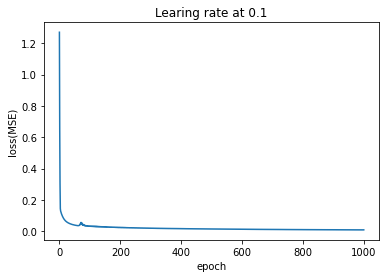

In [33]:
plt.plot(np.arange(len(l_list)), l_list)
plt.ylabel('loss(MSE)')
plt.xlabel('epoch')
plt.title('Learing rate at 0.1')
plt.show()

r2_score is 0.8574492354510213
MSE is 2.121410414464846e-06


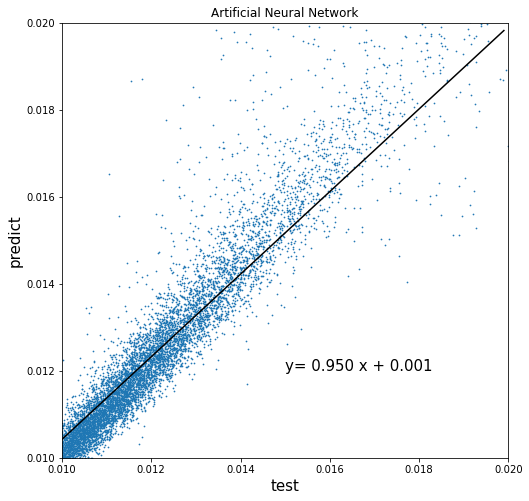

In [34]:
y_va_model=model(x_va_ts)
y_predict=y_va_model.detach().numpy()
y_predict = y_predict/coef

plt.figure(figsize=(8,8))

plt.xlim((0.01, 0.02))
plt.ylim((0.01, 0.02))

plt.xlabel('test',fontsize=15)
plt.ylabel('predict',fontsize=15)
plt.scatter(yV,y_predict,s=0.5)

ax = yV[:,0]
ay = y_predict[:,0]

z5 = np.polyfit(ax,ay,1)  #Linear fitting
x5 = np.arange(0, 0.02, 0.0001)
y5 = x5 * z5[0]+z5[1]
plt.plot(x5, y5,'black')
plt.text(0.015,0.012,'y= %.3f x + %.3f'%(z5[0],z5[1]),fontsize=15)
#plt.text('y= %.3f x + %.3f'%(z5[0],z5[1]),fontsize=15)

plt.title('Artificial Neural Network')
r_ANN=r2_score(yV,y_predict)
print('r2_score is %s'%r_ANN)
MSE_ANN = mean_squared_error(yV,y_predict)
print('MSE is %s'%MSE_ANN)

from sklearn.svm import SVR

#yTr_svr = ravel(-1,1)
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
predict=svr_rbf.fit(XTr, yTr.ravel()).predict(XV)

plt.plot(yV,predict)